# Imports

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
sns.set(font_scale=1.35)

from sklearn.cluster import KMeans
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, LabelEncoder
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import InterclusterDistance

import warnings # Warnungen entfernen (Warnungen sind Hinweise und keine Fehler) -> bessere Übersicht des Codes
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Analysis

#### src: https://www.kaggle.com/datasets/bryanb/aiml-salaries

In [67]:
df = pd.read_csv('salaries.csv')

In [68]:
# copy of original df
df_original = df.copy()

In [69]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Marketing Data Analyst,200000,USD,200000,GB,100,GB,S
1,2022,EN,FT,Data Scientist,96000,CAD,74378,CA,100,CA,L
2,2022,SE,FT,Data Science Lead,165000,USD,165000,US,50,US,S
3,2022,EN,FT,Data Scientist,27000,GBP,33599,GB,50,GB,L
4,2022,SE,FT,Data Engineer,185900,USD,185900,US,0,US,M


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           1195 non-null   int64 
 1   experience_level    1195 non-null   object
 2   employment_type     1195 non-null   object
 3   job_title           1195 non-null   object
 4   salary              1195 non-null   int64 
 5   salary_currency     1195 non-null   object
 6   salary_in_usd       1195 non-null   int64 
 7   employee_residence  1195 non-null   object
 8   remote_ratio        1195 non-null   int64 
 9   company_location    1195 non-null   object
 10  company_size        1195 non-null   object
dtypes: int64(4), object(7)
memory usage: 102.8+ KB


In [71]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,1195.000000,1.195000e+03,1195.000000,1195.000000
mean,2021.684519,2.495210e+05,122041.142259,66.736402
std,0.584604,1.136720e+06,66487.800833,44.035085
min,2020.000000,2.324000e+03,2324.000000,0.000000
25%,2021.000000,8.000000e+04,73961.000000,0.000000
50%,2022.000000,1.300000e+05,120000.000000,100.000000
75%,2022.000000,1.755500e+05,160237.500000,100.000000
max,2022.000000,3.040000e+07,600000.000000,100.000000


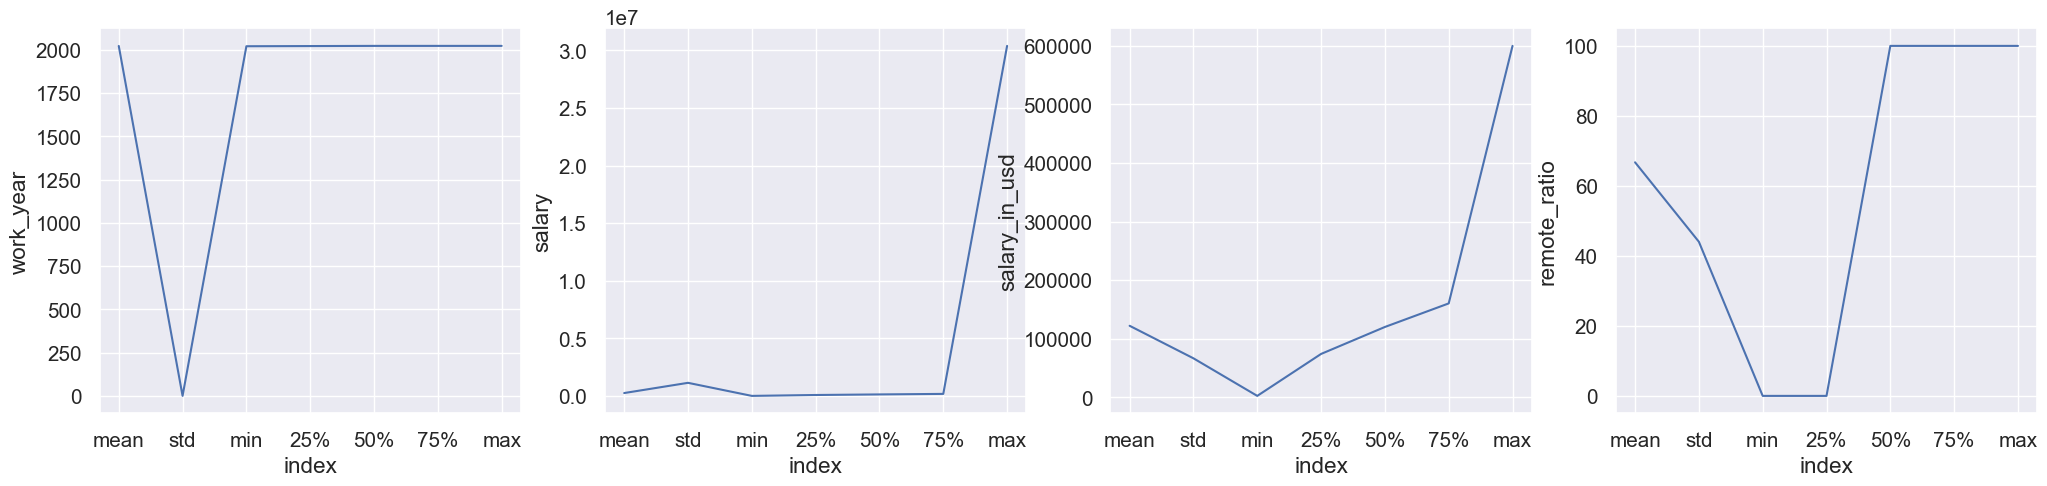

In [72]:
total_columns = df.columns
num_col = df._get_numeric_data().columns
cat_col = list(set(total_columns)-set(num_col))
describe_num_df = df.describe(include=['int64','float64'])  # create df with statistical measurements
describe_num_df.reset_index(inplace=True)
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']  # remove count column

fig, axes = plt.subplots(1, 4, figsize=(25, 5))
j=0
for i in num_col:
    sns.lineplot(ax=axes[j], x='index', y=i, data=describe_num_df)
    j+=1

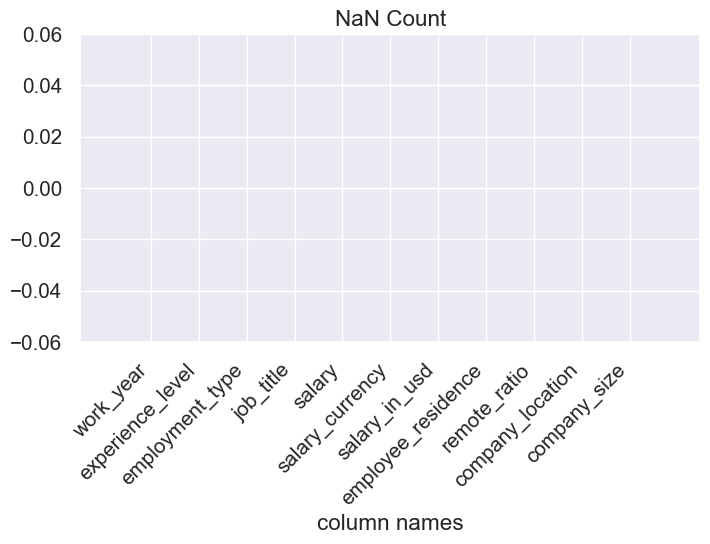

In [73]:
null_df = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')

plt.figure(figsize=(8,4))
plt.bar(null_df.index, null_df['count'])
plt.xticks(null_df.index, null_df.index, rotation=45, horizontalalignment='right')
plt.xlabel('column names')
plt.margins(0.1)
plt.title("NaN Count")
plt.show()

> No Null values

# Visualization

In [74]:
convert_ISO_3166_2_to_1 = {'AF':'AFG','AX':'ALA','AL':'ALB','DZ':'DZA','AS':'ASM','AD':'AND','AO':'AGO','AI':'AIA','AQ':'ATA','AG':'ATG','AR':'ARG','AM':'ARM','AW':'ABW','AU':'AUS','AT':'AUT','AZ':'AZE','BS':'BHS','BH':'BHR','BD':'BGD','BB':'BRB','BY':'BLR','BE':'BEL','BZ':'BLZ',
'BJ':'BEN','BM':'BMU','BT':'BTN','BO':'BOL','BA':'BIH','BW':'BWA','BV':'BVT','BR':'BRA','IO':'IOT','BN':'BRN','BG':'BGR','BF':'BFA','BI':'BDI','KH':'KHM','CM':'CMR','CA':'CAN','CV':'CPV','KY':'CYM','CF':'CAF','TD':'TCD','CL':'CHL','CN':'CHN','CX':'CXR','CC':'CCK','CO':'COL',
'KM':'COM','CG':'COG','CD':'COD','CK':'COK','CR':'CRI','CI':'CIV','HR':'HRV','CU':'CUB','CY':'CYP','CZ':'CZE','DK':'DNK','DJ':'DJI','DM':'DMA','DO':'DOM','EC':'ECU','EG':'EGY','SV':'SLV','GQ':'GNQ','ER':'ERI','EE':'EST','ET':'ETH','FK':'FLK','FO':'FRO','FJ':'FJI','FI':'FIN',
'FR':'FRA','GF':'GUF','PF':'PYF','TF':'ATF','GA':'GAB','GM':'GMB','GE':'GEO','DE':'DEU','GH':'GHA','GI':'GIB','GR':'GRC','GL':'GRL','GD':'GRD','GP':'GLP','GU':'GUM','GT':'GTM','GG':'GGY','GN':'GIN','GW':'GNB','GY':'GUY','HT':'HTI','HM':'HMD','VA':'VAT','HN':'HND','HK':'HKG',
'HU':'HUN','IS':'ISL','IN':'IND','ID':'IDN','IR':'IRN','IQ':'IRQ','IE':'IRL','IM':'IMN','IL':'ISR','IT':'ITA','JM':'JAM','JP':'JPN','JE':'JEY','JO':'JOR','KZ':'KAZ','KE':'KEN','KI':'KIR','KP':'PRK','KR':'KOR','KW':'KWT','KG':'KGZ','LA':'LAO','LV':'LVA','LB':'LBN','LS':'LSO',
'LR':'LBR','LY':'LBY','LI':'LIE','LT':'LTU','LU':'LUX','MO':'MAC','MK':'MKD','MG':'MDG','MW':'MWI','MY':'MYS','MV':'MDV','ML':'MLI','MT':'MLT','MH':'MHL','MQ':'MTQ','MR':'MRT','MU':'MUS','YT':'MYT','MX':'MEX','FM':'FSM','MD':'MDA','MC':'MCO','MN':'MNG','ME':'MNE','MS':'MSR',
'MA':'MAR','MZ':'MOZ','MM':'MMR','NA':'NAM','NR':'NRU','NP':'NPL','NL':'NLD','AN':'ANT','NC':'NCL','NZ':'NZL','NI':'NIC','NE':'NER','NG':'NGA','NU':'NIU','NF':'NFK','MP':'MNP','NO':'NOR','OM':'OMN','PK':'PAK','PW':'PLW','PS':'PSE','PA':'PAN','PG':'PNG','PY':'PRY','PE':'PER',
'PH':'PHL','PN':'PCN','PL':'POL','PT':'PRT','PR':'PRI','QA':'QAT','RE':'REU','RO':'ROU','RU':'RUS','RW':'RWA','BL':'BLM','SH':'SHN','KN':'KNA','LC':'LCA','MF':'MAF','PM':'SPM','VC':'VCT','WS':'WSM','SM':'SMR','ST':'STP','SA':'SAU','SN':'SEN','RS':'SRB','SC':'SYC','SL':'SLE',
'SG':'SGP','SK':'SVK','SI':'SVN','SB':'SLB','SO':'SOM','ZA':'ZAF','GS':'SGS','ES':'ESP','LK':'LKA','SD':'SDN','SR':'SUR','SJ':'SJM','SZ':'SWZ','SE':'SWE','CH':'CHE','SY':'SYR','TW':'TWN','TJ':'TJK','TZ':'TZA','TH':'THA','TL':'TLS','TG':'TGO','TK':'TKL','TO':'TON','TT':'TTO',
'TN':'TUN','TR':'TUR','TM':'TKM','TC':'TCA','TV':'TUV','UG':'UGA','UA':'UKR','AE':'ARE','GB':'GBR','US':'USA','UM':'UMI','UY':'URY','UZ':'UZB','VU':'VUT','VE':'VEN','VN':'VNM','VG':'VGB','VI':'VIR','WF':'WLF','EH':'ESH','YE':'YEM','ZM':'ZMB','ZW':'ZWE'
}
dfGrouped = df.replace({'company_location': convert_ISO_3166_2_to_1, 'employee_residence': convert_ISO_3166_2_to_1})  # convert country codes for plotly map visualization
dfGrouped=dfGrouped.groupby(['employee_residence']).mean()  # group data

In [75]:
import plotly.express as px

map = px.choropleth(dfGrouped, locations=dfGrouped.index,
                        hover_name=dfGrouped.index,
                        color='salary_in_usd',
                        projection='natural earth',
                        title='Mean salary based on employee residence',
                        locationmode="ISO-3",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        range_color=[dfGrouped["salary_in_usd"].min(), dfGrouped["salary_in_usd"].max()])

map.update_layout(title=dict(font=dict(size=28), x=0.5, xanchor='center'), margin=dict(l=60, r=60, t=75, b=50))

# Preprocessing

In [76]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

> We remove all the salary columns exept the salary_in_usd column so we can compare the salaries with the same currency

> salary_in_usd: The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com)

In [77]:
df = df[['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']]

In [78]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')

In [79]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [80]:
# Outlier handling
print("Len df before outlier handling:", len(df))
for i in df._get_numeric_data().columns.tolist():
    df = df[(np.abs(stats.zscore(df[i])) < 3)]
print("Len df after outlier handling:", len(df))

Len df before outlier handling: 1195
Len df after outlier handling: 1185


In [81]:
mapping_experience_level = {'EN': 1,'MI': 2, 'SE': 3, 'EX': 4}
mapping_company_size = {'S': 1, 'M': 2, 'L': 3}
df = df.replace({'company_size': mapping_company_size, 'experience_level': mapping_experience_level})  # Label encoding

encodingPipeline = Pipeline([  # Define the pipeline
    ('ordinalEncoder', OrdinalEncoder(encoding_method='arbitrary', variables=["employee_residence", "company_location"])),
    ('oneHotEnc', fe_OneHotEncoder(top_categories=None, variables=["employment_type"], drop_last=False)),
    ('countEncoder', CountFrequencyEncoder(encoding_method='count', variables=["job_title"]))
])

encodingPipeline.fit(df)  # Fit the pipeline
df = encodingPipeline.transform(df)  # Save data after pipeline to original df

In [82]:
# employment_type onehotencoded column names
EToneHotEncoded_names=[]
for i in encodingPipeline["oneHotEnc"].encoder_dict_["employment_type"]:
    EToneHotEncoded_names.append(f"employment_type_{i}")

In [83]:
scaler = StandardScaler()  # normalize data
columns = ['salary_in_usd']
for i in EToneHotEncoded_names:  # add onehot encoded columnnames to list
    columns.append(i)
df[columns] = scaler.fit_transform(df[columns])

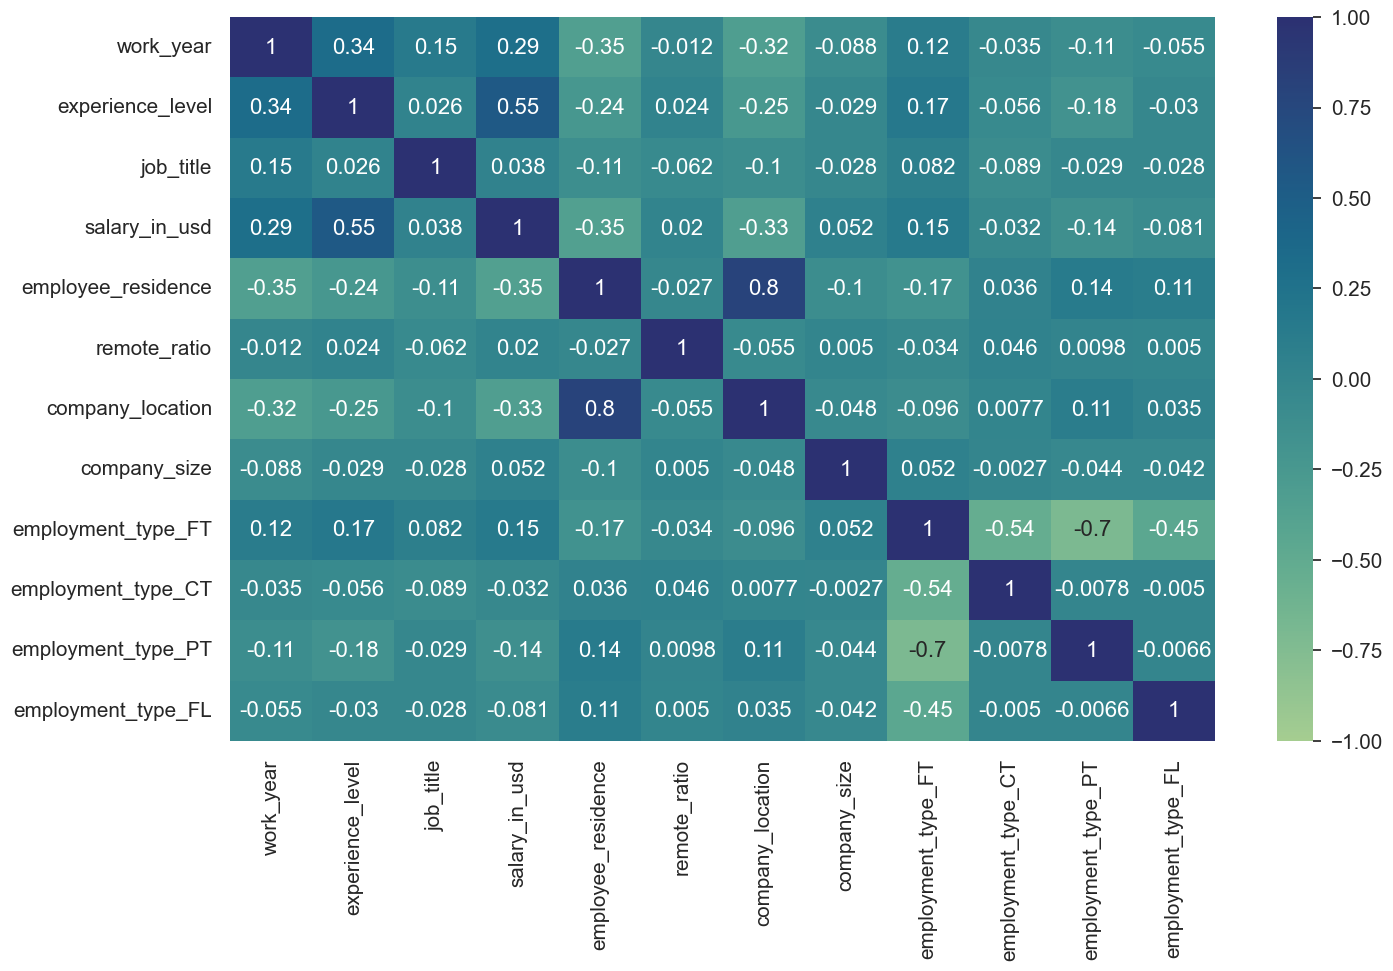

In [84]:
# Correlations
correlations = df.corr(method="pearson")
plt.figure(figsize=(15, 10))
sns.heatmap(correlations, vmin= -1, cmap="crest", annot=True, annot_kws={"fontsize":16})
plt.tight_layout()
plt.show()

In [85]:
# we remove employee_residence because it correlates with company_location and therefore explains almost the same information
del df["employee_residence"]

In [86]:
df.head()

,work_year,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL
0,2022,3,2,1.329896,100,0,1,0.143777,-0.077086,-0.101144,-0.065094
1,2022,1,309,-0.746451,100,1,3,0.143777,-0.077086,-0.101144,-0.065094
2,2022,3,1,0.751397,50,2,1,0.143777,-0.077086,-0.101144,-0.065094
3,2022,1,309,-1.420469,50,0,3,0.143777,-0.077086,-0.101144,-0.065094
4,2022,3,275,1.096844,0,2,2,0.143777,-0.077086,-0.101144,-0.065094


# ML

## K Analysis

### Gap statistic

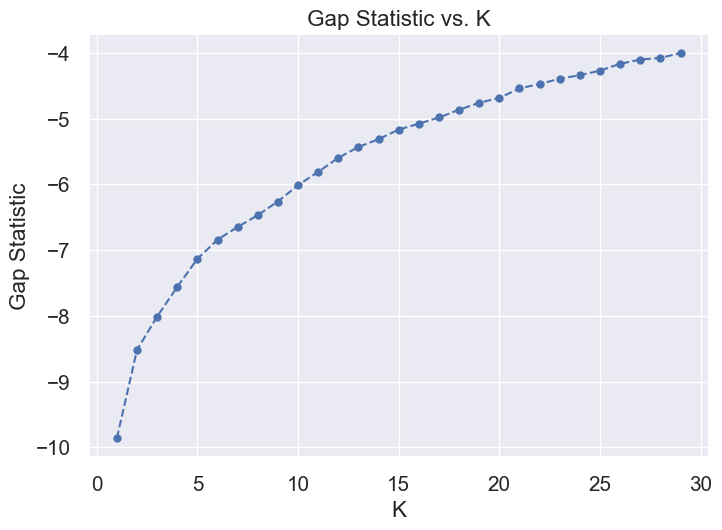

In [87]:
# Gap Statistic for K means
# src: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
    # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
    # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
    # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
    # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

score_g, df_gap = optimalK(df, nrefs=5, maxClusters=30)
plt.plot(df_gap['clusterCount'], df_gap['gap'], linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs. K')
plt.show()

### Elbow plot

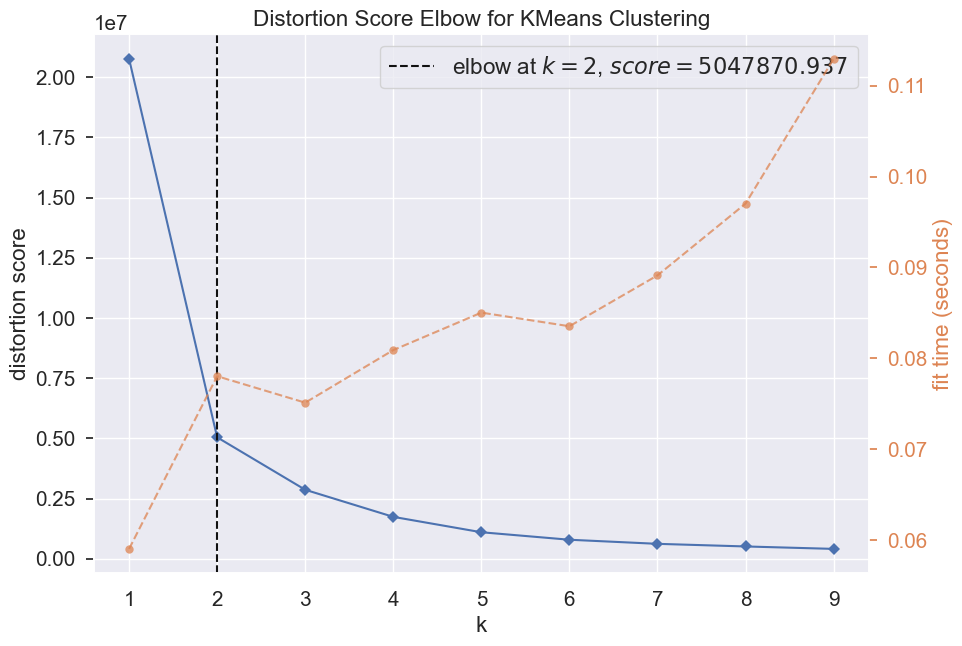

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10),size=(1000, 700))
visualizer.fit(df)
visualizer.show()

### Silhouette plot

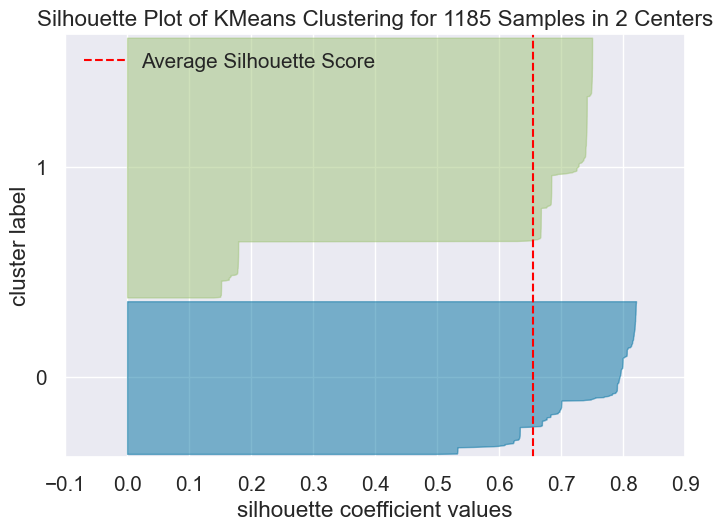

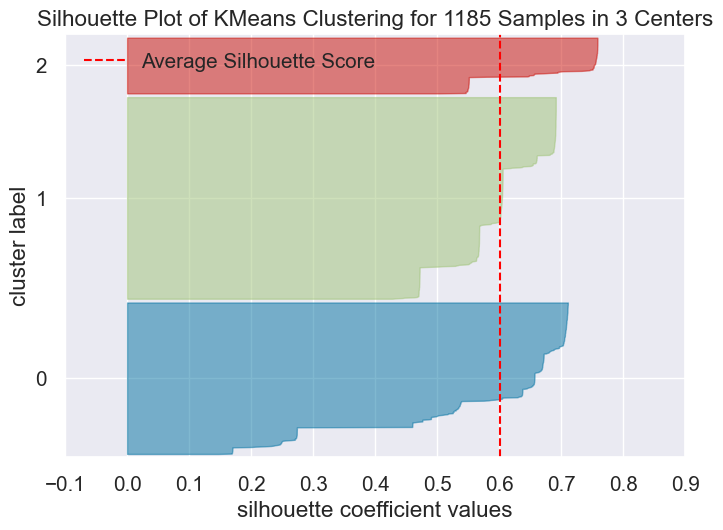

In [89]:
for i in range(2,4):
    silhouette_visualizer(KMeans(i, random_state=11), df, colors='yellowbrick')

## ML: Specific columns

> Specific Columns according to correlations

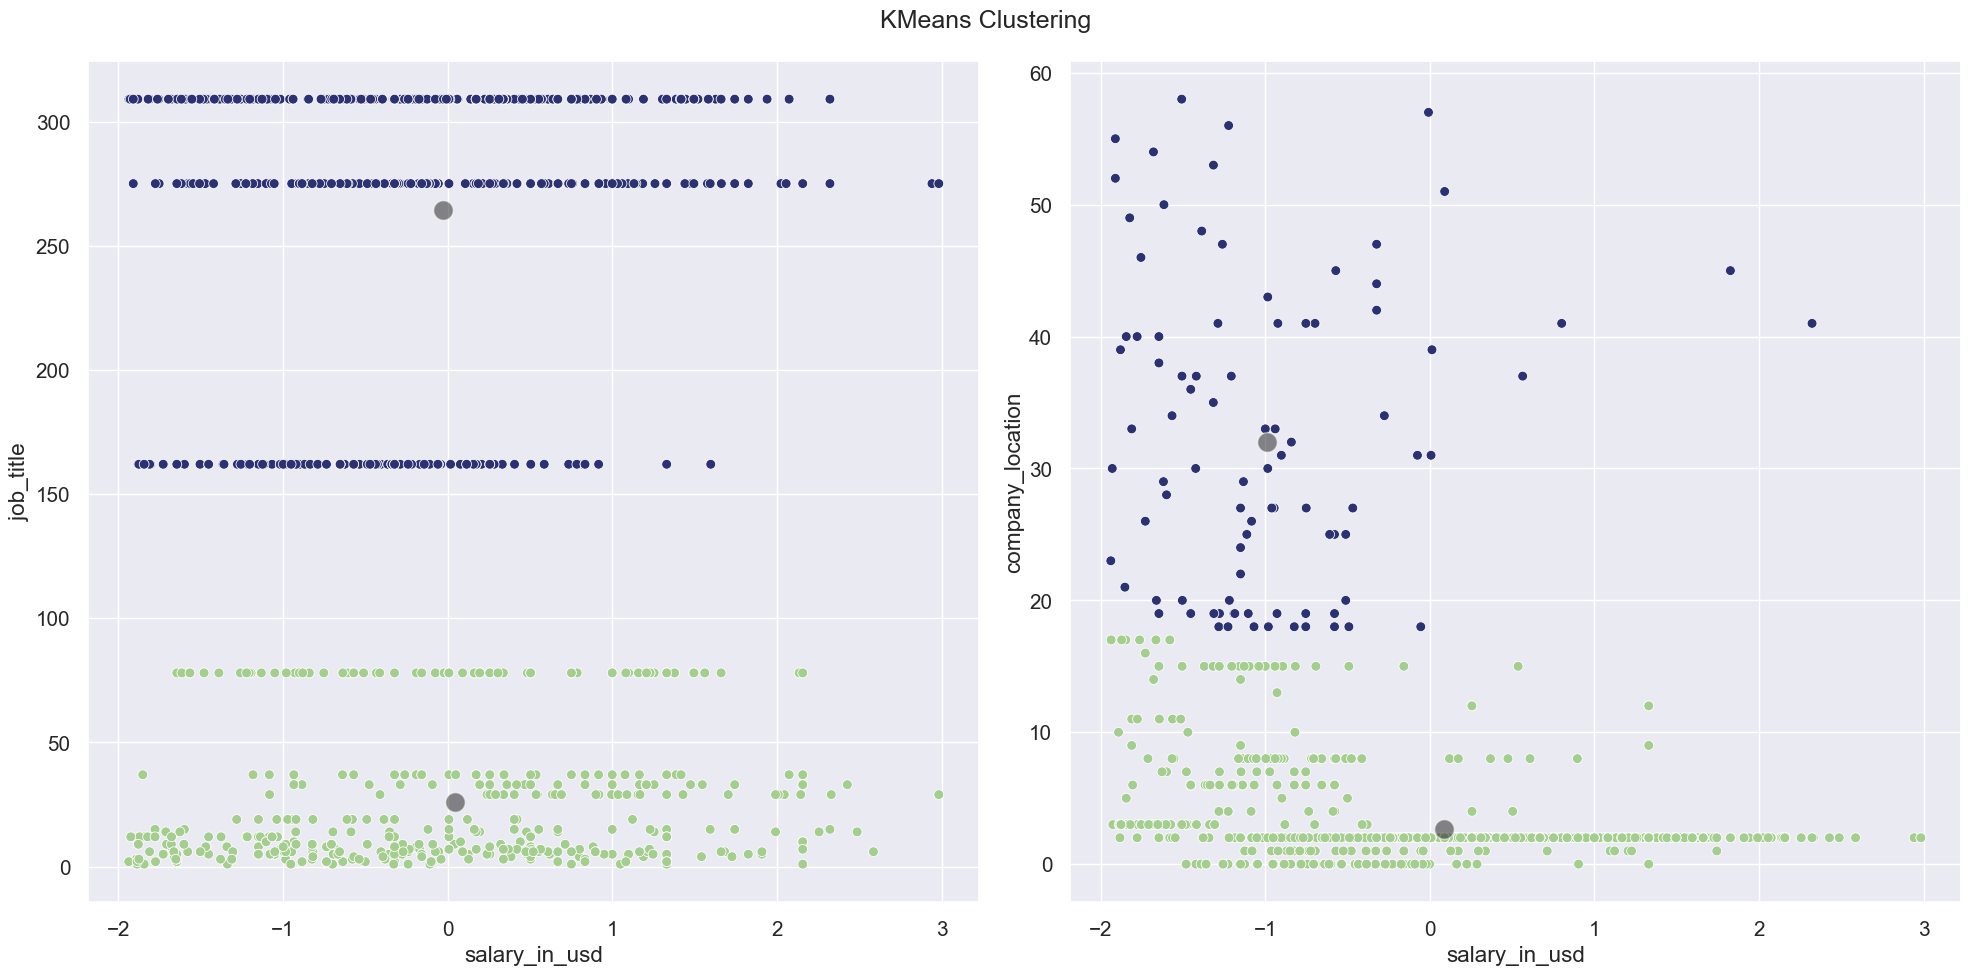

In [90]:
i = 1
dfkmean = df.copy()
kmean_clusters = [["salary_in_usd", "job_title"], ["salary_in_usd", "company_location"]]

plt.figure(figsize=(20, 10))
plt.suptitle("KMeans Clustering", fontsize=18)

for cluster in kmean_clusters:
    X_kmean = dfkmean[cluster]
    kmeans = KMeans(n_clusters=2, random_state=14)
    kmeans.fit(X_kmean)
    y_kmeans = kmeans.predict(X_kmean)
    dfkmean[f"Cluster{i}"] = y_kmeans
    plt.subplot(1, 2, i)
    sns.scatterplot(X_kmean.loc[:, cluster[0]], X_kmean.loc[:, cluster[1]], c=y_kmeans, s=50, cmap="crest")
    centers = kmeans.cluster_centers_
    sns.scatterplot(centers[:, 0], centers[:, 1], s=200, color="k", alpha=0.5)
    i+=1
plt.tight_layout()
plt.show()

## ML: All columns

In [91]:
k_meansDF=df.copy()

k_means = KMeans(n_clusters=2)
k_means.fit(k_meansDF)

k_meansDF["cluster_index"] = k_means.predict(k_meansDF)

<AxesSubplot:xlabel='cluster_index', ylabel='salary_in_usd'>

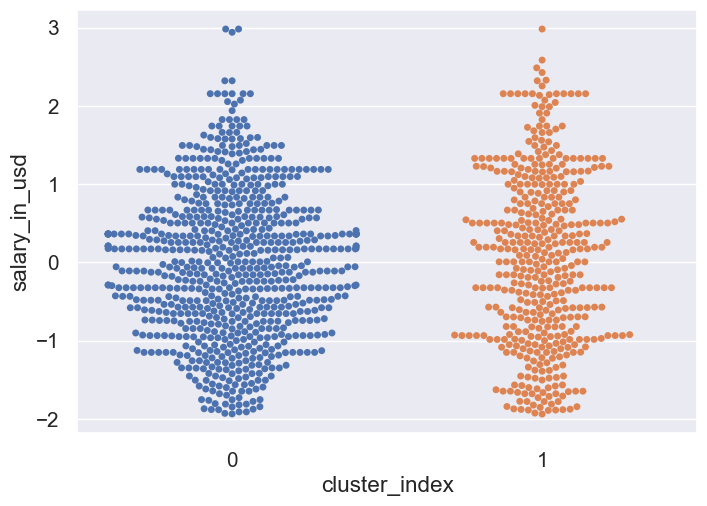

In [92]:
sns.swarmplot(k_meansDF.cluster_index, k_meansDF['salary_in_usd'])

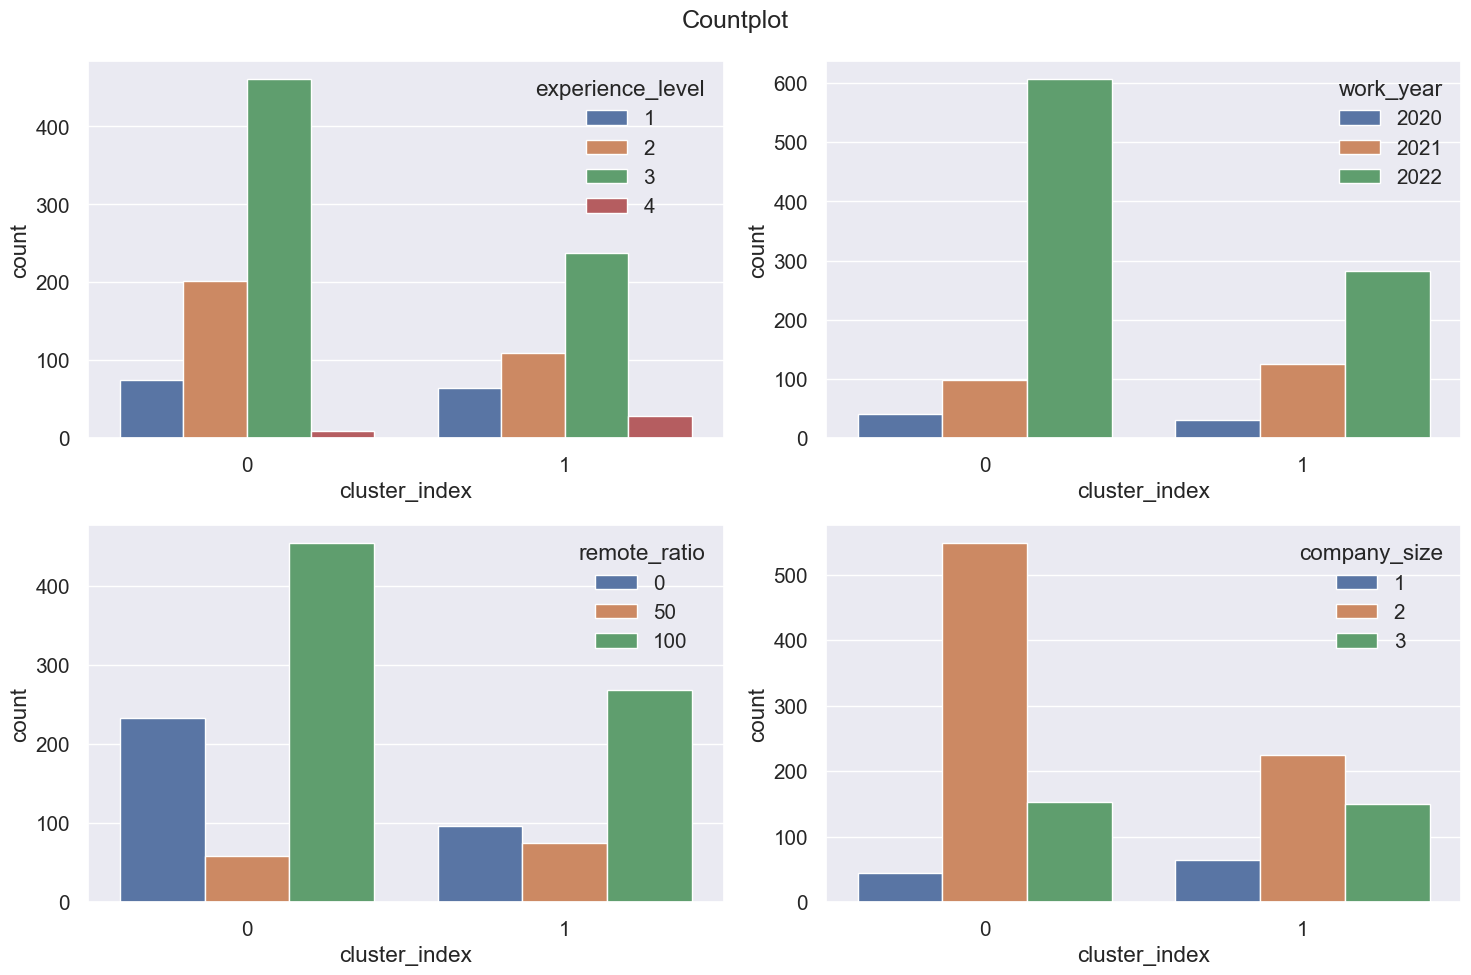

In [93]:
plt.figure(figsize=(15, 10))
plt.suptitle("Countplot", fontsize=18)
plt.subplot(2, 2, 1)
sns.countplot(x='cluster_index', hue='experience_level', data=k_meansDF)
plt.subplot(2, 2, 2)
sns.countplot(x='cluster_index', hue='work_year', data=k_meansDF)
plt.subplot(2, 2, 3)
sns.countplot(x='cluster_index', hue='remote_ratio', data=k_meansDF)
plt.subplot(2, 2, 4)
sns.countplot(x='cluster_index', hue='company_size', data=k_meansDF)
plt.tight_layout()

### With dimensionality reduction

#### src: https://dhakal-bek.medium.com/clustering-in-unsupervised-categorical-data-7f10db4bb9fc

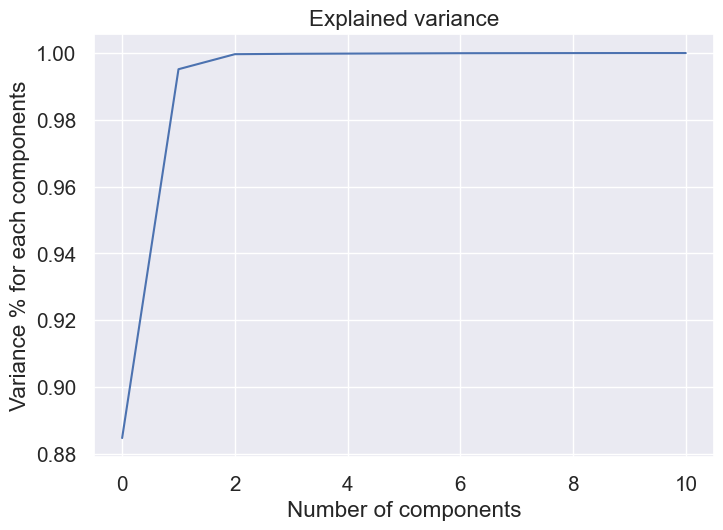

In [94]:
pca=PCA().fit(df)  # fitting the pca algorithm with our data
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))  # plotting the cumulative summation of the explained variance
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance')
plt.show()

> 2 Components for 100% of explained variance

In [95]:
pca=PCA(n_components=2)
pca.fit(df)
x_pca=pca.transform(df)

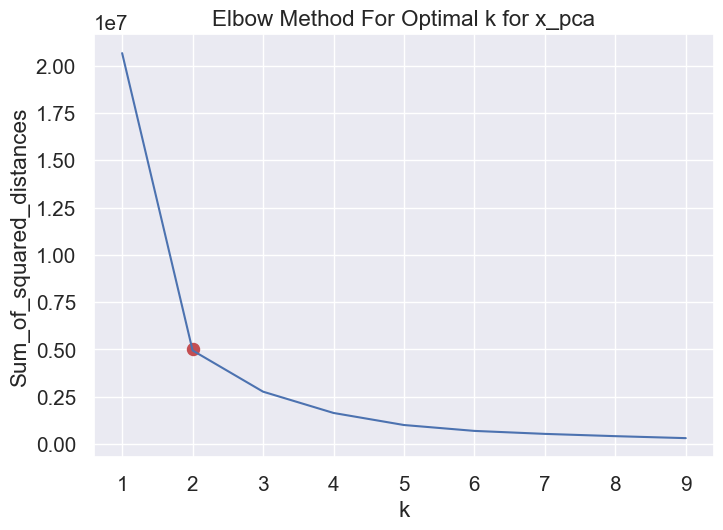

In [96]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x_pca)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.scatter(x=2, y=5000000, s=75, c='r')  # elbow coordinates
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for x_pca')
plt.show()

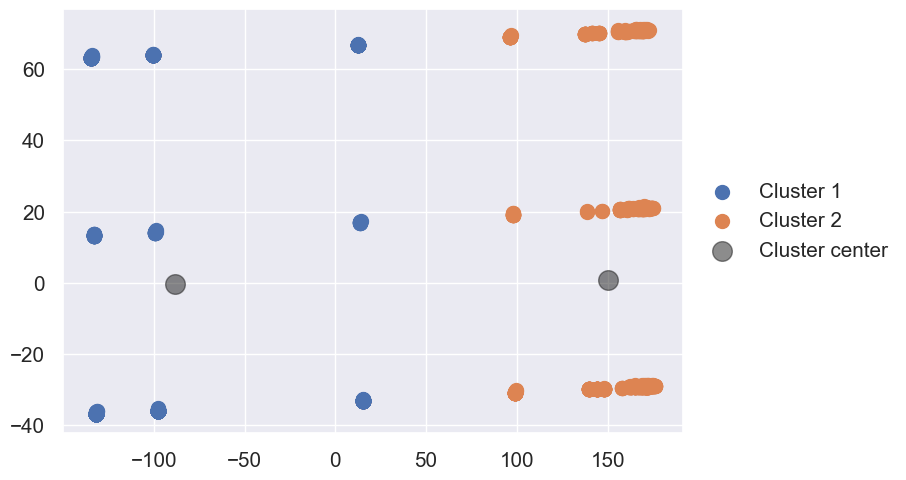

In [97]:
kmeans_pca = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, random_state=None, copy_x=True)
kmeans_pca.fit(x_pca)
y_kmeans_pca = kmeans_pca.predict(x_pca)
plt.scatter(x_pca[y_kmeans_pca==0,0], x_pca[y_kmeans_pca==0,1], s=100, label='Cluster1')
plt.scatter(x_pca[y_kmeans_pca==1,0], x_pca[y_kmeans_pca==1,1], s=100, label='Cluster2')
centers_pca = kmeans_pca.cluster_centers_
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, color="k", alpha=0.5)
plt.legend(['Cluster 1', 'Cluster 2', 'Cluster center'], loc='center left', bbox_to_anchor=(1, 0.5))

**End of Notebook**